In [1]:
import os
import glob
import sys
sys.path.append('../../activedrops')

import autocorrelation
import pivdrops
import viz
viz.set_plotting_style()

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
def load_and_convert_data(file_path):
    """
    Load data from a specified file path and convert units.
    
    Parameters:
    - file_path (str): Path to the data file.
    
    Returns:
    - DataFrame: Processed data with columns 'x [um]', 'y [um]', 'u [um/s]', and 'v [um/s]'.
    """
    
    # Load the data
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity units
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Retain only the converted columns
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df


def compute_full_product(data):
    """
    Compute the full product of the Fourier transform of data with its complex conjugate.
    
    Parameters:
    - data (ndarray): 2D array containing velocity magnitudes or other spatial data.
    
    Returns:
    - ndarray: Product of the Fourier transform of data with its complex conjugate.
    """
    return np.fft.fft2(data) * np.conj(np.fft.fft2(data))

def direct_spatial_autocorrelation_from_full_product(full_product, shape, r):
    """
    Compute the direct spatial autocorrelation from the full product of Fourier transforms.
    
    Parameters:
    - full_product (ndarray): Product of the Fourier transform of data with its complex conjugate.
    - shape (tuple): Shape of the original data array.
    - r (int): Spatial lag value for which autocorrelation should be computed.
    
    Returns:
    - float: Spatial autocorrelation value for the specified spatial lag r.
    """
    inverse = np.real(np.fft.ifft2(full_product))
    return (inverse[r, r] + inverse[-r, -r]) / (shape[0] * shape[1])

# Define the exponential decay function
def exponential_decay(r, A, xi, C):
    return A * np.exp(-r / xi) + C


def compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values):
    """
    Compute the normalized spatial autocorrelation for a single frame.
    
    Parameters:
    - tt (int): Frame number.
    - UX, UY (ndarray): 2D arrays representing the x and y components of velocity, respectively.
    - r_values (list): List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - tuple: Frame number and the list of normalized computed autocorrelation values for specified r_values.
    """
    magnitude = np.sqrt(UX**2 + UY**2)
    full_product = compute_full_product(magnitude)
    results = [direct_spatial_autocorrelation_from_full_product(full_product, magnitude.shape, r) for r in r_values]
    
    # Normalize the results by the autocorrelation value at r=0
    R_0 = results[0]
    normalized_results = [r / R_0 for r in results]
    
    return tt, normalized_results

# Now, we recompute the autocorrelation using the normalized function
def compute_autocorrelation_for_frames(file_paths, r_values):
    """
    Compute normalized spatial autocorrelation for multiple frames.
    
    Parameters:
    - file_paths (list): List of file paths for each frame.
    - r_values (list): List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - dict: Dictionary with keys as frame number and values as computed normalized autocorrelation.
    """
    results = {}
    
    for file_path in file_paths:
        # Load and convert data
        df = load_and_convert_data(file_path)
        
        # Reshape velocities for processing
        reshape_dim = int(np.sqrt(df.shape[0]))
        UX, UY = df['u [um/s]'].values.reshape((reshape_dim, reshape_dim)), df['v [um/s]'].values.reshape((reshape_dim, reshape_dim))
        
        # Compute normalized autocorrelation for the frame
        frame_num = int(file_path.split('_')[-1].split('.')[0])
        _, autocorr_values = compute_autocorrelation_for_one_time_simple(frame_num, UX, UY, r_values)
        
        results[frame_num] = autocorr_values
        
    return results




In [3]:
input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))

# Define the range of r values for which autocorrelation should be computed
r_values_custom = list(range(1, 50))
# Display the function signature and docstring
results_multiple_frames = compute_autocorrelation_for_frames(file_paths, r_values_custom)


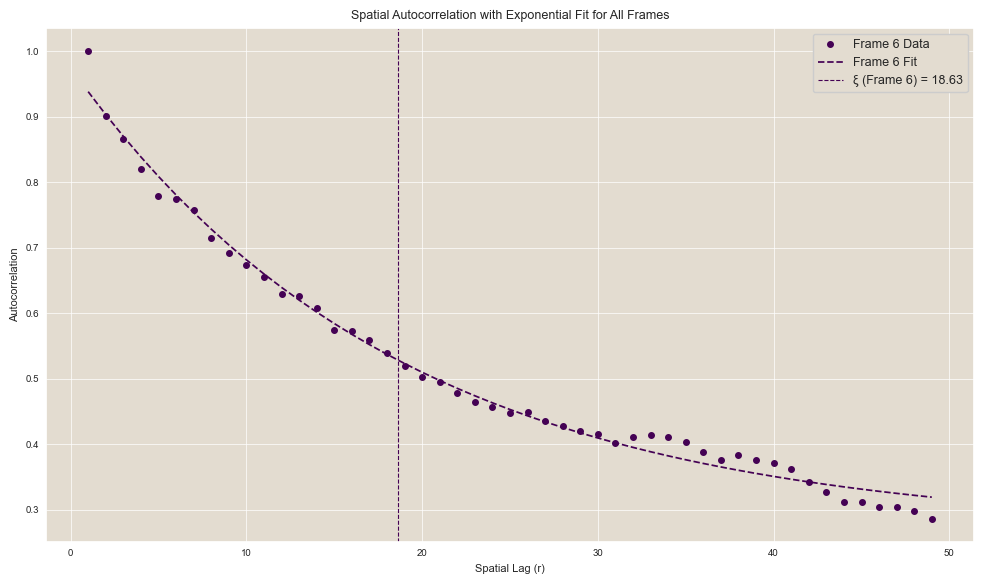

In [17]:
# Generate dynamic colors based on number of frames using a colormap
def generate_dynamic_colors(n):
    """
    Generate a list of distinct colors based on the number of frames using a colormap.
    
    Parameters:
    - n (int): Number of required colors.
    
    Returns:
    - list: List of RGBA colors.
    """
    colormap = plt.cm.viridis  # using the 'viridis' colormap, but this can be changed to any other colormap
    return [colormap(i) for i in np.linspace(0, 1, n)]

# Modify the plot_autocorrelation_with_fit function to use dynamic colors
def plot_autocorrelation_with_fit_dynamic_colors(results, r_values):
    """
    Plot spatial autocorrelation with exponential fit for provided results.
    
    Parameters:
    - results (dict): Dictionary with keys as frame number and values as computed autocorrelation.
    - r_values (list): List of spatial lags for which autocorrelation has been computed.
    
    Returns:
    - None: Displays the plot.
    """
    
    plt.figure(figsize=(10, 6))
    
    # Get dynamic colors based on the number of frames
    colors = generate_dynamic_colors(len(results))

    for idx, (frame_num, autocorr_values) in enumerate(results.items()):
        # Informed guesses for fit parameters
        A_guess = autocorr_values[0]
        C_guess = np.mean(autocorr_values[-5:])
        xi_guess = next((r for r, value in zip(r_values, autocorr_values) if value <= A_guess / 2), 20)
        
        # Fit the spatial autocorrelation data with informed guesses
        params_informed, _ = curve_fit(exponential_decay, r_values, autocorr_values, p0=[A_guess, xi_guess, C_guess])
        A_fit, xi_fit, C_fit = params_informed

        # Generate the fitted values for visualization
        fitted_values = exponential_decay(np.array(r_values), A_fit, xi_fit, C_fit)

        # Plot the original and fitted autocorrelation data for the frame
        plt.plot(r_values, autocorr_values, 'o', color=colors[idx], label=f"Frame {frame_num} Data", markersize=4)
        plt.plot(r_values, fitted_values, '--', color=colors[idx], label=f"Frame {frame_num} Fit")
        plt.axvline(xi_fit, color=colors[idx], linestyle='--', linewidth=0.8, label=f"ξ (Frame {frame_num}) = {xi_fit:.2f}")

    plt.xlabel('Spatial Lag (r)')
    plt.ylabel('Autocorrelation')
    plt.title('Spatial Autocorrelation with Exponential Fit for All Frames')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Return the function to check if there are any errors
plot_autocorrelation_with_fit_dynamic_colors(dict(list(results_multiple_frames.items())[5:6]), r_values_custom)


In [5]:
def get_correlation_length_dataframe(file_paths, results, r_values):
    """
    Process autocorrelation data, fit exponential decay, and return a DataFrame with correlation lengths.
    
    Parameters:
    - file_paths (list): List of file paths for each frame.
    - results (dict): Dictionary with keys as frame number and values as computed autocorrelation.
    - r_values (list): List of spatial lags for which autocorrelation has been computed.
    
    Returns:
    - DataFrame: DataFrame with columns for time (in minutes), file name, and correlation length.
    """
    
    correlation_lengths = []
    
    for file_path, (frame_num, autocorr_values) in zip(file_paths, results.items()):
        # Informed guesses for fit parameters
        A_guess = autocorr_values[0]
        C_guess = np.mean(autocorr_values[-5:])
        xi_guess = next((r for r, value in zip(r_values, autocorr_values) if value <= A_guess / 2), 20)
        
        # Fit the spatial autocorrelation data with informed guesses
        params_informed, _ = curve_fit(exponential_decay, r_values, autocorr_values, p0=[A_guess, xi_guess, C_guess])
        _, xi_fit, _ = params_informed
        
        if xi_fit <= 500:
            correlation_lengths.append([frame_num * 3 / 60, file_path.split('/')[-1], xi_fit])
        
    return pd.DataFrame(correlation_lengths, columns=['Time (min)', 'File Name', 'Correlation Length'])


# Test the function with the previous file paths and results
# Note: We'll re-run the compute_autocorrelation_for_frames function to get the results for this test
results_multiple_frames = compute_autocorrelation_for_frames(file_paths, r_values_custom)
df_correlation_length = get_correlation_length_dataframe(file_paths, results_multiple_frames, r_values_custom)
df_correlation_length


,Time (min),File Name,Correlation Length
0,0.05,PIVlab_0001.txt,22.860318
1,0.10,PIVlab_0002.txt,18.528855
2,0.15,PIVlab_0003.txt,25.848133
3,0.20,PIVlab_0004.txt,24.072502
4,0.25,PIVlab_0005.txt,19.978693
...,...,...,...
2791,141.60,PIVlab_2832.txt,35.058872
2792,141.65,PIVlab_2833.txt,40.183009
2793,141.70,PIVlab_2834.txt,31.994680
2794,141.75,PIVlab_2835.txt,32.994029


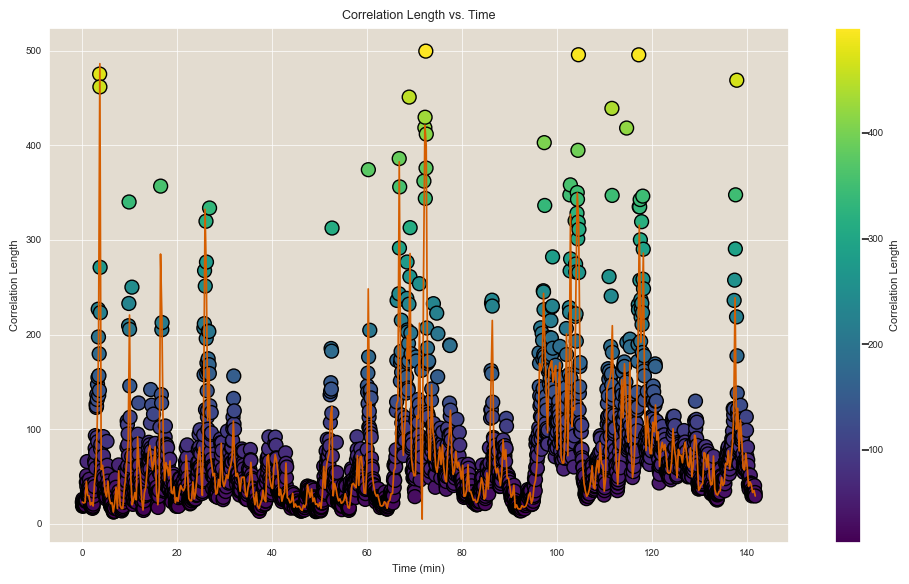

In [14]:
from scipy.interpolate import CubicSpline

def plot_correlation_length_vs_time(df_correlation_length, filename=None):
    """
    Plot correlation length against time using provided DataFrame, color the y-values with a heatmap in viridis,
    and connect the points with an interpolated line.
    
    Parameters:
    - df_correlation_length (DataFrame): DataFrame with columns for time (in minutes) and correlation length.
    
    Returns:
    - None: Displays the plot.
    """
    
    plt.figure(figsize=(10, 6))
    
    # Use scatter for heatmap coloring
    plt.scatter(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'], 
                c=df_correlation_length['Correlation Length'], cmap='viridis', s=100, edgecolors='black')
    
    # Interpolate using cubic spline
    cs = CubicSpline(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'])
    times = np.linspace(df_correlation_length['Time (min)'].min(), df_correlation_length['Time (min)'].max(), 500)
    plt.plot(times, cs(times), 'r-')
    
    # Optional: Add a colorbar to indicate the correlation length values
    plt.colorbar(label='Correlation Length')
    
    plt.xlabel('Time (min)')
    plt.ylabel('Correlation Length')
    plt.title('Correlation Length vs. Time')
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
        
    if filename:
        plt.savefig(filename, format='jpg', dpi=200)
    else:
        plt.show()
  

# Test the function with the df_correlation_length DataFrame
plot_correlation_length_vs_time(df_correlation_length, "../../data/k401bio-250nM-piv/plots/Rvstime.jpg")



In [7]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar
from bokeh.layouts import column
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
def plot_correlation_length_vs_time(df_correlation_length):
    """
    Plot correlation length against time using provided DataFrame with Bokeh, color the y-values with a heatmap in viridis,
    and connect the points with an interpolated line. Tooltips display the correlation length on hover.
    
    Parameters:
    - df_correlation_length (DataFrame): DataFrame with columns for time (in minutes) and correlation length.
    
    Returns:
    - None: Displays the interactive plot.
    """
    
    # Interpolate using cubic spline
    cs = CubicSpline(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'])
    times = np.linspace(df_correlation_length['Time (min)'].min(), df_correlation_length['Time (min)'].max(), 500)
    
    # Set up the Bokeh plot
    p = figure(width=800, height=400, title='Correlation Length vs. Time with Interpolation',
               x_axis_label='Time (min)', y_axis_label='Correlation Length', tools='')
    
    # Add the data points with hover info
    mapper = linear_cmap(field_name='Correlation Length', palette=Viridis256, 
                         low=min(df_correlation_length['Correlation Length']), 
                         high=max(df_correlation_length['Correlation Length']))
    
    source = ColumnDataSource(df_correlation_length)
    p.scatter(x='Time (min)', y='Correlation Length', source=source, size=10, color=mapper, 
              legend_label='Data Points', alpha=1)  # Added alpha for transparency
    
    # Add the interpolated line (after scatter to ensure it's on top)
    p.line(times, cs(times), line_color='orange', line_width=2)
    
    # Add hover tool
    hover = HoverTool()
    hover.tooltips = [("Correlation Length", "@{Correlation Length}")]
    p.add_tools(hover)
    
    # Color bar
    color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
    p.add_layout(color_bar, 'right')
    
    output_notebook()
    show(p)

# Test the modified function with the df_correlation_length DataFrame
plot_correlation_length_vs_time(df_correlation_length)


Loading BokehJS ...

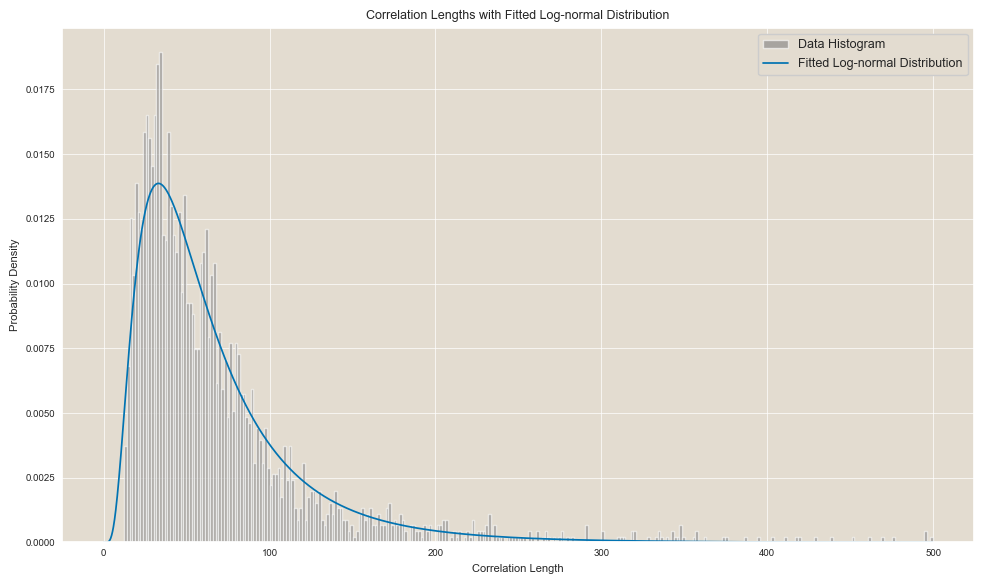

In [19]:
from scipy.stats import lognorm

# Fit the data to a log-normal distribution
shape, loc, scale = lognorm.fit(df_correlation_length['Correlation Length'], floc=0)

# Generate x values for plotting
x_values_lognorm = np.linspace(0, df_correlation_length['Correlation Length'].max(), len(df_correlation_length['Correlation Length']))
y_values_lognorm = lognorm.pdf(x_values_lognorm, shape, loc, scale)

# Plot the histogram of the correlation lengths and the fitted log-normal distribution
plt.figure(figsize=(10, 6))
plt.hist(df_correlation_length['Correlation Length'], bins=300, density=True, alpha=0.6, color='gray', label='Data Histogram')
plt.plot(x_values_lognorm, y_values_lognorm, 'b-', label='Fitted Log-normal Distribution')
plt.title('Correlation Lengths with Fitted Log-normal Distribution')
plt.xlabel('Correlation Length')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../../data/k401bio-250nM-piv/plots/Rvstime-pdf.jpg", format='jpg', dpi=200)
plt.show()

